##Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries



In [2]:
import random
import os
#print(os.listdir("../drive"))
print(os.listdir("/content/drive/My Drive/deep_learning_project"))

['image_transform_net.py', 'checkpoints', 'images', 'style_images', 'imagenet-vgg-verydeep-19.mat', 'output_images', '__pycache__', 'vgg.py', 'stylize.py', 'test_images', 'graphs', 'neural_style.py', 'static', 'static.zip', 'templates.zip']


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
!pip install scipy==1.1.0
!pip install tensorflow==1.4.0
!pip install PIL==4.2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==1.4.0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==1.4.0
ERROR: Could not find a version that satisfies the requirement PIL==4.2.1 (from versions: none)
ERROR: No matching distribution found for PIL==4.2.1


In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'/content/drive/My Drive/deep_learning_project')
import image_transform_net

Instructions for updating:
non-resource variables are not supported in the long term


## Helper Function to Save Image in Your Disk

Fist, let's build a function to save image.

In [6]:
def save_image(image, file_path):
    '''
    Save an image as a jpg file. The image is given as 
    a numpy array with pixel values between 0 and 255.
    
    :param image:
        The numpy array of the image.
        type: ndarray
    :param file_path:
        The full path to save the mixed image, 
        i.e. image path + image name
        type: str
    :return:
        Save the image as a jpeg file.
    '''
    
    # Ensure the pixel values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image file in jpeg format.
    with open(file_path, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

## Since we already have a pre-trained checkpoint, we will use it to generate a mixed image.

In [7]:
def feed_forward(image_path, output_path, checkpoint_dir, style_path=None):
    '''
    :param image_path:
        The path and filename that you are going to tranfer.
        type: str
    :param style_path:
        The path and filename of the style image.
        This is just for displaying and has nothing with 
        the evaluation.
        type: str
    :param output_path:
        The path to store the mixed image, including its filename.
        type: str
    :param checkpoint_dir:
        The path and filename of the pre-trained checkpoint.
        type: str
    :return:
        Save the mixed image and display image.
    '''
    
    # Build a graph and a session.
    with tf.Graph().as_default(), tf.compat.v1.Session()  as sess:
        # Read content image from a file as a numpy array.
        content_image = mpimg.imread(image_path)
        
        # Read style image from a file if provided.
        if style_path is not None:
            style_image = mpimg.imread(style_path)
        
        # Since image transform net requires a 4-D array,
        # we'll have to expand a dimension at axis = 0.
        content_image = np.expand_dims(content_image, axis=0)
        
        # Define a 4-D placeholder for image.
        image_holder = tf.compat.v1.placeholder(
            tf.float32, content_image.shape, 'input_image')
        
        # Let image flow through image transform net.
        output_image = image_transform_net.net(image_holder)
        
        # Restore the pre-trained checkpoint.
        saver = tf.train.Saver()
        saver.restore(sess, checkpoint_dir)
        
        # Run the session.
        feed_dict = {image_holder: content_image}
        mixed_image = sess.run(output_image, feed_dict)
        
        # Save the mixed image.
        with open(output_path, 'wb') as file:
            save_image(mixed_image[0], output_path)
        
        # If style image is provided, display content, mixed, style image.
        if style_path is not None:
            fig, axes = plt.subplots(1, 3, figsize=(20, 20))
            
        # If style image is not provided, display content, mixed image.
        else:
            fig, axes = plt.subplots(1, 2, figsize=(20, 20))
        
        # Use interpolation to smooth pixels
        smooth = True

        # Interpolation type.
        if smooth:
            interpolation = 'sinc'
        else:
            interpolation = 'nearest'
            
        # Plot the content image.
        # Note that the pixel values are normalized to
        # the [0.0, 1.0] range by dividing with 255.
        ax = axes.flat[0]
        ax.imshow(content_image[0] / 255.0, interpolation=interpolation)
        ax.set_xlabel('Content')

        # Plot the mixed image.
        ax = axes.flat[1]
        ax.imshow(mixed_image[0] / 255.0, interpolation=interpolation)
        ax.set_xlabel('Mixed')
        
        if style_path is not None:
            # Plot the style image
            ax = axes.flat[2]
            ax.imshow(style_image / 255.0, interpolation=interpolation)
            ax.set_xlabel("Style")
        
        # Remove ticks from all the plots.
        for ax in axes.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()


## Running



In [8]:
print("Content images are:")
print(os.listdir("/content/drive/My Drive/deep_learning_project/images"))
print("Style images are:")
print(os.listdir("/content/drive/My Drive/deep_learning_project/style_images"))


Content images are:
['tower.jpg']
Style images are:
['udnie.jpg', 'scream.jpg', 'rain_princess.jpg', 'wave.jpg', 'la_muse.jpg', 'reck.jpg', 'bridge.jpg', 'the_starry_night.jpg']


###You can set from of the style and content images listed above.

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/deep_learning_project/checkpoints/udnie.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


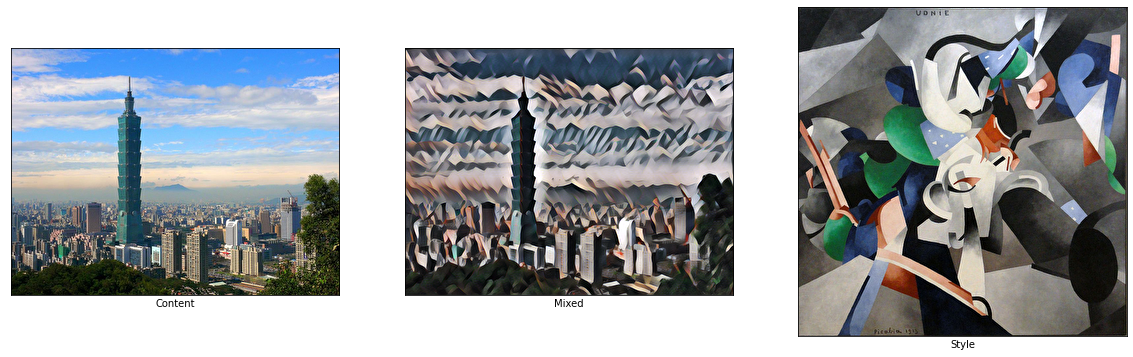

In [9]:
style_image="udnie"
content_image="tower"
INPUT_PATH = "/content/drive/My Drive/deep_learning_project/images/"+content_image+".jpg"
OUTPUT_PATH = "/content/drive/My Drive/deep_learning_project/output_images/"+style_image+"_"+content_image+".jpg"
CHECKPOINT_DIR = "/content/drive/My Drive/deep_learning_project/checkpoints/"+style_image+".ckpt"
# Optional. Only for displaying it.
STYLE_PATH = "/content/drive/My Drive/deep_learning_project/style_images/"+style_image+".jpg"

feed_forward(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)
# Run the code.


##Importing libaries for web application

In [10]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask


In [11]:
!unzip '/content/drive/My Drive/deep_learning_project/templates.zip' 
!unzip '/content/drive/My Drive/deep_learning_project/static.zip'

Archive:  /content/drive/My Drive/deep_learning_project/templates.zip
replace templates/theme.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace templates/index.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/My Drive/deep_learning_project/static.zip
replace static/images/output.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [12]:
def output(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH):
    feed_forward(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)

Once this cell runs you will see output like
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   WARNING: This is a development server. Do not use it in a production deployment.
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Running on http://270d-35-185-47-213.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
 
Click on Link on fifth point or link containing ngrok.io in it ,for example: http://270d-35-185-47-213.ngrok.io

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7bf0-34-90-228-69.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [20/Nov/2021 10:22:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:10] "GET /static/images/themes/scream.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:10] "GET /static/images/themes/la_muse.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:10] "GET /static/images/themes/reck.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:10] "GET /static/images/background/bg.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:10] "GET /static/images/input/input1.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:10] "GET /static/images/input/input2.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:11] "GET /static/images/themes/udnie.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:11] "GET /static/images/themes/wave.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:11] "GET /static/images/themes/rain_princess.jpg HTTP/1.1" 200 -
127.0.0.1 - - [20/Nov/2021 10:22:13] "GET /favicon.ico HTTP/1.1" 404 -


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/deep_learning_project/checkpoints/reck.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


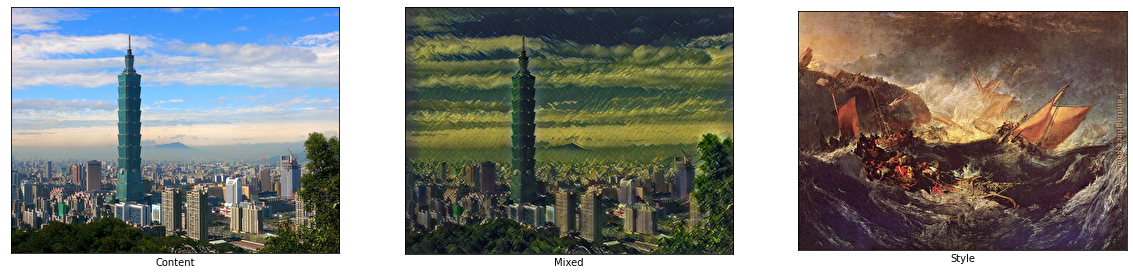

127.0.0.1 - - [20/Nov/2021 10:22:24] "POST / HTTP/1.1" 200 -


In [13]:
from flask import Flask, redirect, render_template, request, url_for, send_file
import os
from flask_ngrok import run_with_ngrok
from werkzeug.wrappers import Request, Response

app = Flask(__name__)
run_with_ngrok(app)
@app.route('/',methods=['POST','GET'])
def index():
    if request.method == "POST":
       # getting input with name = fname in HTML form
       theme = request.form.get("seltheme")
       # getting input with name = lname in HTML form 
       img = request.form.get("selinput") 
       INPUT_PATH = 'static/images/input/'+img+'.jpg'
       OUTPUT_PATH = 'static/images/output.jpg'
       CHECKPOINT_DIR = '/content/drive/My Drive/deep_learning_project/checkpoints/'+theme+'.ckpt'
       STYLE_PATH = 'static/images/themes/'+theme+'.jpg' # Optional. Only for displaying it.
       
       img = output(INPUT_PATH, OUTPUT_PATH, CHECKPOINT_DIR, STYLE_PATH)
       return send_file(OUTPUT_PATH, mimetype='image/gif')
    return render_template('theme.html')

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    app.run()

###You can refresh the site to enter new details.